### Project 3: Tracking User Activity
## Presto Analysis
## Team: Greg Tully, Ferdous Alam, Ricardo Jenez
## Date: 04/11/2021

## Introduction 
This is example documentation for you, our data scientiists, to come up to speed quickly on our data stream for currencies. 
 
## Use Of Presto 
While processing the data in the messages and using Prest to examine and query the data. The coin data is continuously updating, so you can build live charts if you decide to do so.

### Example Queries
- Format of the streaming data.

```
     -root
         |-- name: string (nullable = false)
         |-- symbol: string (nullable = true)
         |-- id: string (nullable = false)
         |-- current_price: string (nullable = false)
         |-- last_update: string (nullable = false)
 
```




## Summary 
The cluster and data pipeline that has been built allows us to stream live data for crypto currencies that we may want to do market assessments on.



## Data Analysis Process 
### Setup and Preparation Steps
#### Start with setting up the environment

In [1]:
# Setup up environment

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.functions import explode, split
from pyspark.sql.types import *
from pyhive import presto
import warnings
import json
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import copy

## Example Queries
### Answers To Core Questions

### First Prepare And Look For The Data To Read From HDFS

In [2]:
# Setup presto
presto_conn = presto.Connection(host="presto", port=8080)
presto_cursor=presto_conn.cursor()
presto_cursor.execute('show tables')
print(presto_cursor.fetchone())


('coin_quotes',)


### What is the % return for each coin  over the total time period?

In [11]:
query= """WITH _data AS
  (SELECT id,
          min(last_updated)_min,
          max(last_updated)_max
   FROM coin_quotes
   GROUP BY id)
SELECT DISTINCT a.id, d._min As "Period Start",
d._max As "Period End",
--from_iso8601_timestamp(d._max),
--from_iso8601_timestamp(d._min),
a.current_price,
b.current_price,

date_diff('Day', from_iso8601_date(substr(d._min, 1, 10)), from_iso8601_date(substr(d._max, 1, 10))) AS "Days",
                                 round((((CAST(b.current_price AS DOUBLE)/ CAST(a.current_price AS DOUBLE))-1)*100),4) AS
                                 "Return"
FROM _data d
JOIN coin_quotes a ON d._min = a.last_updated
AND d.id = a.id
JOIN coin_quotes b ON d._max = b.last_updated
AND d.id = b.id
ORDER BY "Return" DESC"""

presto_cursor.execute(query)
#print(presto_cursor.fetchall())

df = pd.DataFrame(presto_cursor.fetchall())


# Add coluimn headers
df.columns =['Coin ID', 'Start Date', 'End Date','Initial Price', 'Current Price',
             'Number of Days in Period','Return']


# Format Output
df['Start Date'] = pd.to_datetime(df['Start Date'], format='%Y-%m-%dT%H:%M:%S')
df['End Date'] = pd.to_datetime(df['End Date'], format='%Y-%m-%dT%H:%M:%S').dt.date
df['Initial Price']=df['Initial Price'].astype(float).apply(lambda x: "USD {:,.2f}".format((x)))
df['Current Price']=df['Current Price'].astype(float).apply(lambda x: "USD {:,.2f}".format((x)))
df['Number of Days in Period']=df['Number of Days in Period'].apply(lambda x : "{:,}".format(x))
df['Return']=df['Return'].astype(float).apply(lambda x: "{:,.2f}%".format((x)))
df

,Coin ID,Start Date,End Date,Initial Price,Current Price,Number of Days in Period,Return
0,ethereum,2015-08-07,2021-04-11,USD 2.83,"USD 2,139.06","2,074","75,441.92%"
1,bitcoin,2013-04-28,2021-04-11,USD 135.30,"USD 59,518.00","2,905","43,889.65%"
2,litecoin,2018-07-08,2021-04-11,USD 84.50,USD 252.75,"1,008",199.11%


  
### What is the price return for each coin over the last 5 minutes?

In [4]:
query1="""WITH _now AS
  (SELECT DISTINCT AA.id,
                   AA.last_updated,
                   current_price AS "Now"
   FROM coin_quotes AA
   JOIN
     (SELECT DISTINCT id,
                      max(last_updated)_now
      FROM coin_quotes
      GROUP BY id)BB ON AA.id = BB.id
   AND AA.last_updated = BB._now),
     _previous AS
  (SELECT DISTINCT AA.id,
                   AA.last_updated,
                   current_price AS "_lastfiveminago"
   FROM coin_quotes AA
   JOIN
     (SELECT x.id,
             min(x.last_updated) _lastfiveminago
      FROM coin_quotes x
      JOIN
        (SELECT id,
                max(last_updated) _max
         FROM coin_quotes
         GROUP BY id) y ON x.id = y.id
      AND from_iso8601_timestamp(last_updated) > from_iso8601_timestamp(_max) + interval '-5' MINUTE
      GROUP BY x.id) BB ON AA.id = BB.id
   AND AA.last_updated = BB._lastfiveminago)
SELECT _now.id,
from_iso8601_timestamp(_previous.last_updated),
from_iso8601_timestamp(_now.last_updated),
       date_diff('second', from_iso8601_timestamp(_previous.last_updated), from_iso8601_timestamp(_now.last_updated)) AS "Actual Seconds Since last Price",
       round((((CAST(NOW AS DOUBLE)/ CAST(_lastfiveminago AS DOUBLE))-1)*100),4) AS " Percentage (%) Return Over last 5 minutes"
FROM _now
JOIN _previous ON _now.id = _previous.id"""

presto_cursor.execute(query1)
#print(presto_cursor.fetchall())

df = pd.DataFrame(presto_cursor.fetchall())


# Add coluimn headers
df.columns =['Coin ID', 'Start Time', 'Latest Date','Time Elapsed in Seconds','Return']

# Format Output
df['Return']=df['Return'].astype(float).apply(lambda x: "{:,.4f}%".format((x)))
df



,Coin ID,Start Time,Latest Date,Time Elapsed in Seconds,Return
0,bitcoin,2021-04-11 14:22:17.496 UTC,2021-04-11 14:25:55.891 UTC,218,0.0084%
1,ethereum,2021-04-11 14:23:15.179 UTC,2021-04-11 14:26:38.116 UTC,202,0.0192%
2,litecoin,2021-04-11 14:23:22.966 UTC,2021-04-11 14:27:04.592 UTC,221,0.3071%


In [6]:
print('The Percentage Return for: ')
for index, row in df.iterrows():
    print('{0} was {1}, with elapsed time of {2} seconds, between Latest and Previous price, in the last 5 minute window'
          .format(row['Coin ID'],row['Return'], row['Time Elapsed in Seconds']))

The Percentage Return for: 
bitcoin was 0.0084%, with elapsed time of 218 seconds, between Latest and Previous price, in the last 5 minute window
ethereum was 0.0192%, with elapsed time of 202 seconds, between Latest and Previous price, in the last 5 minute window
litecoin was 0.3071%, with elapsed time of 221 seconds, between Latest and Previous price, in the last 5 minute window



### Display the Price chart of the Crypto currency over the last hour

In [7]:
query2 = "select * From coin_quotes"
presto_cursor.execute(query2)
df = pd.DataFrame(presto_cursor.fetchall())
df.columns =['Coin Name', 'Coin ID', 'Coin Symbol','Current Price', 'TimeStamp']


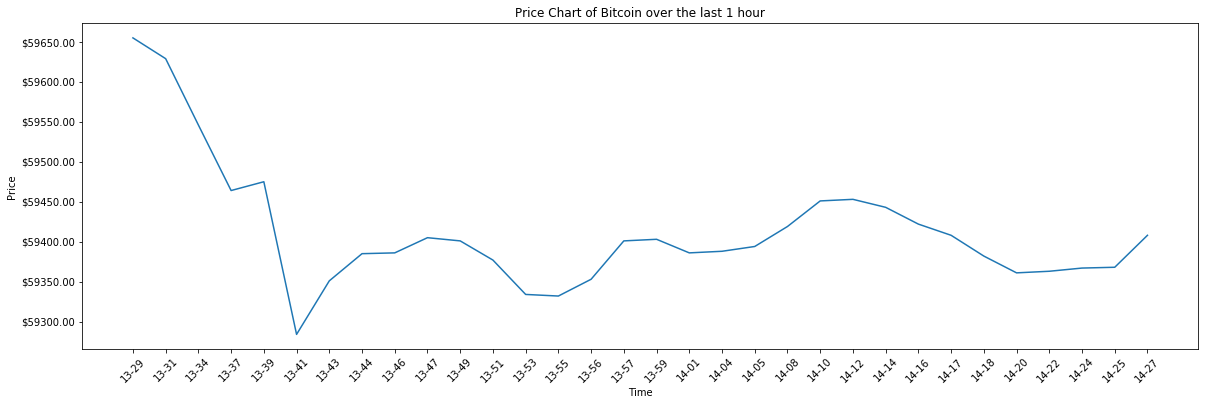

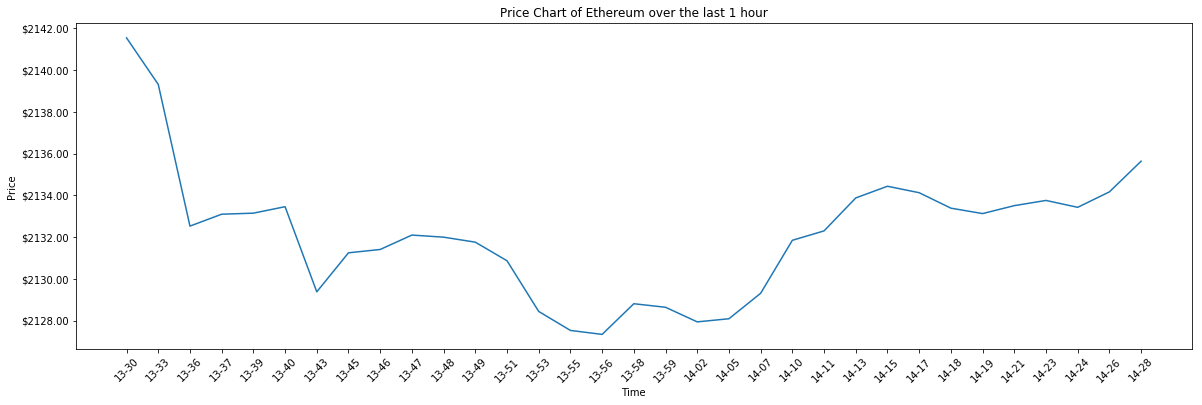

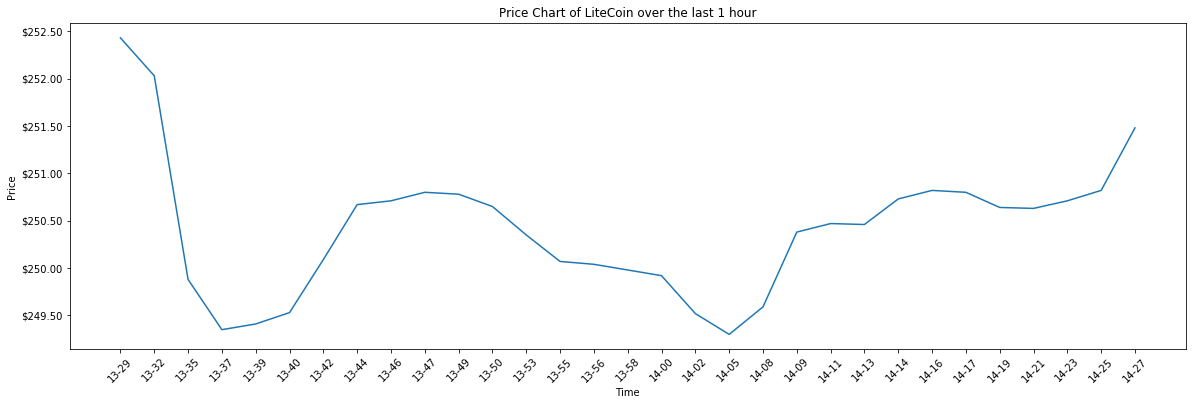

In [8]:
plt.rcParams["figure.figsize"] = (20,6)

btc_t = copy.deepcopy(df[df['Coin Symbol'] == 'btc'])
btc_t['TimeStamp'] = pd.to_datetime(btc_t['TimeStamp'], format='%Y-%m-%dT%H:%M:%S')
max_btc = btc_t['TimeStamp'].max()
min_btc = max_btc- timedelta(minutes=60)
btc_gr = btc_t[btc_t['TimeStamp']>min_btc][['Current Price', 'TimeStamp']]
btc_gr['Current Price'] = btc_gr['Current Price'].astype(float)
btc_gr = btc_gr.drop_duplicates(['Current Price','TimeStamp'])
btc_gr = btc_gr.sort_values(by=['TimeStamp'], ascending=False)
btc_gr['TimeStamp'] = btc_gr['TimeStamp'].dt.strftime('%H-%M')


eth_t = copy.deepcopy(df[df['Coin Symbol'] == 'eth'])
eth_t['TimeStamp'] = pd.to_datetime(eth_t['TimeStamp'], format='%Y-%m-%dT%H:%M:%S')
max_eth = eth_t['TimeStamp'].max()
min_eth = max_eth- timedelta(minutes=60)
eth_gr = eth_t[eth_t['TimeStamp']>min_eth][['Current Price', 'TimeStamp']]
eth_gr['Current Price'] = eth_gr['Current Price'].astype(float)
eth_gr = eth_gr.drop_duplicates(['Current Price','TimeStamp'])
eth_gr = eth_gr.sort_values(by=['TimeStamp'], ascending=False)
eth_gr['TimeStamp'] = eth_gr['TimeStamp'].dt.strftime('%H-%M')


ltc_t = copy.deepcopy(df[df['Coin Symbol'] == 'ltc'])
ltc_t['TimeStamp'] = pd.to_datetime(ltc_t['TimeStamp'], format='%Y-%m-%dT%H:%M:%S')
max_ltc = ltc_t['TimeStamp'].max()
min_ltc = max_ltc- timedelta(minutes=60)
ltc_gr = ltc_t[ltc_t['TimeStamp']>min_ltc][['Current Price', 'TimeStamp']]
ltc_gr['Current Price'] = ltc_gr['Current Price'].astype(float)
ltc_gr = ltc_gr.drop_duplicates(['Current Price','TimeStamp'])
ltc_gr = ltc_gr.sort_values(by=['TimeStamp'], ascending=False)
ltc_gr['TimeStamp'] = ltc_gr['TimeStamp'].dt.strftime('%H-%M')

################################## Draw the charts ######################
fig, ax = plt.subplots()
time =btc_gr['TimeStamp']
price = btc_gr['Current Price']
formatter = ticker.FormatStrFormatter('$%1.2f')
ax.yaxis.set_major_formatter(formatter)
plt.title('Price Chart of Bitcoin over the last 1 hour')
plt.xlabel("Time")
plt.ylabel("Price")
plt.plot(time, price)
plt.xticks(rotation=45)
plt.rcParams["figure.figsize"] = (20,6)
plt.show()


fig, ax = plt.subplots()
time =eth_gr['TimeStamp']
price = eth_gr['Current Price']
formatter = ticker.FormatStrFormatter('$%1.2f')
ax.yaxis.set_major_formatter(formatter)
plt.title('Price Chart of Ethereum over the last 1 hour')
plt.xlabel("Time")
plt.ylabel("Price")
plt.plot(time, price)
plt.xticks(rotation=45)
plt.rcParams["figure.figsize"] = (20,6)
plt.show()


fig, ax = plt.subplots()
time =ltc_gr['TimeStamp']
price = ltc_gr['Current Price']
formatter = ticker.FormatStrFormatter('$%1.2f')
ax.yaxis.set_major_formatter(formatter)
plt.title('Price Chart of LiteCoin over the last 1 hour')
plt.xlabel("Time")
plt.ylabel("Price")
plt.plot(time, price)
plt.xticks(rotation=45)
plt.rcParams["figure.figsize"] = (20,6)
plt.show()



In [ ]:
## Close cursor when done
# cursor.close()